## Предсказание эмоциональной окраски отзыва на основе анализа естественного языка (Практическая часть)

Вам для обработки предлагается коллекция рецензий пользователей на фильмы с сайта kinopoisk.ru

Положительных: 87101 

Отрицательных: 19804

Нейтральных: 24678


Все: 131583

Каждая рецензия в отдельном файле, первая часть названия файла соответствует ID фильма на kinopoisk.ru вторая часть номеру рецензии на этот фильм. Например, имя файла 306-15.txt обозначает идентификатор фильма на сайте 306, номер рецензии 15.

https://www.kaggle.com/mikhailklemin/kinopoisks-movies-reviews

Произведем загрузку набора данных.

In [113]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings(action="ignore")
import tensorflow as tf

In [114]:
%%capture
!wget https://www.dropbox.com/s/myqjozyhxiionc3/dataset.zip

In [115]:
from zipfile import ZipFile
zip = ZipFile('/kaggle/working/dataset.zip')
zip.extractall()

In [116]:
import os
import pandas as pd

df = pd.DataFrame(columns=['review','sentiment'])

path = '/kaggle/working/dataset/'

for directory in os.listdir(path):
    print(directory)
    if os.path.isdir(path + directory):
        for filename in os.listdir(path + directory):
            with open(os.path.join(path + directory + '/', filename)) as f:
                review = f.read()
                current_df = pd.Series({'review': review, 'sentiment': directory})
                df = pd.concat([df, pd.DataFrame([current_df])], ignore_index=True)

pos
neg
neu


In [117]:
df_copy = df

In [118]:
df = df.sample(frac=1).reset_index(drop=True)

Вашим заданием в данной лабораторной будет построение модели анализа естественного языка для определения эмоциональной окраски отзыва.

*Примечание*: размер датасета не позволяет обрабатывать его полностью силами бесплатного аккаунта Colab. Для того, чтобы избежать аварийного завершения работы блокнота из-за дефицита оперативной памяти, рекомендуется проводить обучение в несколько этапов с промежуточным сохранением модели. 

Методика оценки - accuracy_score (В обучении и тестировании должно участвовать не менее 60000 записей, их распределение по классам должно стремиться к равномерному, т.е. 20к-20к-20к)

In [119]:
df

,review,sentiment
0,"Молодой парень, задушивший свою девушку, прост...",pos
1,Криминальная драма 'Гавань' (в оригинале - 'Ha...,pos
2,"В гостях хорошо, а дома ещё лучше. Вот и полюб...",pos
3,Для того чтобы увидеть значимость данного филь...,pos
4,"Полански, конечно, гений. Не успели еще отойти...",pos
...,...,...
131664,Каждое утро человек завтракает старыми хлопьям...,pos
131665,"Этот фильм я смотрела с сестрой, в принципе ни...",neu
131666,Steve Wozniak: What do you do? You're not an e...,neu
131667,Главная героиня переживает разного рода пробле...,neu


In [120]:
df.shape

(131669, 2)

In [121]:
df.isna().sum()

review       0
sentiment    0
dtype: int64

In [122]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 131669 entries, 0 to 131668
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   review     131669 non-null  object
 1   sentiment  131669 non-null  object
dtypes: object(2)
memory usage: 2.0+ MB


In [123]:
le = LabelEncoder()
df["sentiment"] = le.fit_transform(df["sentiment"])
df.head()

,review,sentiment
0,"Молодой парень, задушивший свою девушку, прост...",2
1,Криминальная драма 'Гавань' (в оригинале - 'Ha...,2
2,"В гостях хорошо, а дома ещё лучше. Вот и полюб...",2
3,Для того чтобы увидеть значимость данного филь...,2
4,"Полански, конечно, гений. Не успели еще отойти...",2


In [124]:
df.sentiment.unique()

array([2, 1, 0])

<Axes: xlabel='sentiment', ylabel='count'>

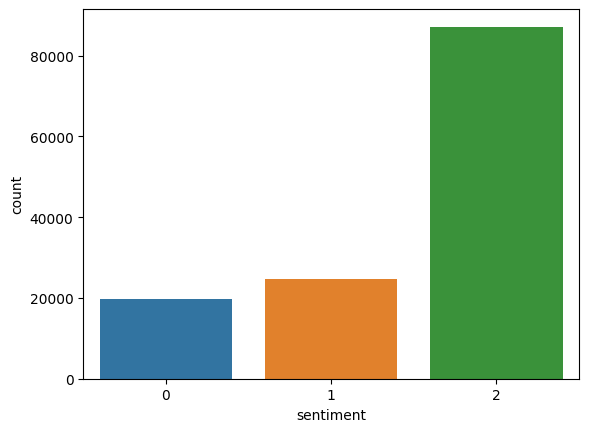

In [125]:
sns.countplot(df, x="sentiment")

In [126]:
df["sentiment"].value_counts()

sentiment
2    87138
1    24704
0    19827
Name: count, dtype: int64

In [127]:
y = df['sentiment']
X = df.drop(columns=('sentiment'))

In [128]:
X.shape

(131669, 1)

In [129]:
from imblearn.under_sampling import RandomUnderSampler

rus = RandomUnderSampler()
X_resampled, y_resampled = rus.fit_resample(X, y)

small_df = X_resampled

In [130]:
small_df['sentiment'] = y_resampled
small_df = small_df.sample(frac = 1)

In [131]:
small_df['sentiment'].value_counts()

sentiment
2    19827
1    19827
0    19827
Name: count, dtype: int64

In [132]:
X_resampled = small_df.drop(columns=('sentiment'))
y_resampled = small_df['sentiment']

In [133]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer


nltk.download('stopwords')
stop_words = set(stopwords.words('russian'))
stemmer = SnowballStemmer('russian')

def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'[^\w\s]', '', text)
    tokens = word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words]
    tokens = [stemmer.stem(word) for word in tokens]
    preprocessed_text = ' '.join(tokens)
    return preprocessed_text

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [134]:
X_resampled_1 = X_resampled.iloc[:15000]
y_resampled_1 = y_resampled.iloc[:15000]
X_resampled_1['review'] = X_resampled_1['review'].apply(preprocess_text)

In [135]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score

X_train, X_test, y_train, y_test = train_test_split(X_resampled_1['review'], y_resampled_1, test_size=0.3, random_state=42)

tfidf_vectorizer = TfidfVectorizer()
svm_classifier = SVC(kernel='linear')

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

svm_classifier.fit(X_train_tfidf, y_train)
y_pred = svm_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6395555555555555

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.72      0.71      1447
           1       0.54      0.52      0.53      1555
           2       0.69      0.68      0.69      1498

    accuracy                           0.64      4500
   macro avg       0.64      0.64      0.64      4500
weighted avg       0.64      0.64      0.64      4500



In [136]:
X_resampled_2 = X_resampled.iloc[15000:30000]
y_resampled_2 = y_resampled.iloc[15000:30000]
X_resampled_2['review'] = X_resampled_2['review'].apply(preprocess_text)

X_train, X_test, y_train, y_test = train_test_split(X_resampled_2['review'], y_resampled_2, test_size=0.3, random_state=42)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

svm_classifier.fit(X_train_tfidf, y_train)
y_pred = svm_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6348888888888888

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.68      0.69      1524
           1       0.51      0.54      0.53      1508
           2       0.72      0.68      0.70      1468

    accuracy                           0.63      4500
   macro avg       0.64      0.64      0.64      4500
weighted avg       0.64      0.63      0.64      4500



In [137]:
X_resampled_3 = X_resampled.iloc[30000:45000]
y_resampled_3 = y_resampled.iloc[30000:45000]
X_resampled_3['review'] = X_resampled_3['review'].apply(preprocess_text)

X_train, X_test, y_train, y_test = train_test_split(X_resampled_3['review'], y_resampled_3, test_size=0.3, random_state=42)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

svm_classifier.fit(X_train_tfidf, y_train)
y_pred = svm_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6502222222222223

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.71      0.71      1524
           1       0.51      0.51      0.51      1442
           2       0.71      0.73      0.72      1534

    accuracy                           0.65      4500
   macro avg       0.65      0.65      0.65      4500
weighted avg       0.65      0.65      0.65      4500



In [138]:
X_resampled_4 = X_resampled.iloc[45000:]
y_resampled_4 = y_resampled.iloc[45000:]
X_resampled_4['review'] = X_resampled_4['review'].apply(preprocess_text)

X_train, X_test, y_train, y_test = train_test_split(X_resampled_4['review'], y_resampled_4, test_size=0.3, random_state=42)

X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

svm_classifier.fit(X_train_tfidf, y_train)
y_pred = svm_classifier.predict(X_test_tfidf)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.6407364787111622

Classification Report:
               precision    recall  f1-score   support

           0       0.69      0.70      0.69      1472
           1       0.52      0.48      0.50      1425
           2       0.70      0.73      0.72      1448

    accuracy                           0.64      4345
   macro avg       0.64      0.64      0.64      4345
weighted avg       0.64      0.64      0.64      4345



Обучение в 4 подхода на сокращенных данных(уравнение по классам) показало точность в 64 процента